In [1]:
import os
import sys
import hashlib
import zipfile
import json
import csv
import numpy as np
import re
import pandas as pd

import matplotlib.pyplot as plt

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.text import TSNEVisualizer

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import scipy
import networkx as nx
import spacy
import nltk

from nltk.tokenize import RegexpTokenizer

from itertools import tee, islice
from collections import Counter
import re

try:
    import requests
except ImportError:
    print((
        "The requests module is required to download data --\n"
        "please install it with pip install requests."
    ))
    sys.exit(1)

In [2]:
# download functions is ADAPTED FROM

# download
# Downloads the example datasets for running the examples.
#
# Author:   Rebecca Bilbro <rbilbro@districtdatalabs.com>
# Author:   Benjamin Bengfort <bbengfort@districtdatalabs.com>
# Author:   Raul Peralta <raulpl25@gmail.com>
# Created:  Wed May 18 11:54:45 2016 -0400
#
# Copyright (C) 2016 District Data Labs
# For license information, see LICENSE.txt
#
# ID: download.py [1f73d2b] benjamin@bengfort.com $

"""
Downloads the example datasets for running the examples.
"""

'\nDownloads the example datasets for running the examples.\n'

In [3]:
##########################################################################
## Links and MD5 hash of datasets
##########################################################################

DATASETS = {
    'hobbies': {
        'url': 'https://s3.amazonaws.com/ddl-data-lake/yellowbrick/hobbies.zip',
        'signature': '415c8f68df1486d5d84a1d1757a5aa3035aef5ad63ede5013c261d622fbd29d8'}
}


##########################################################################
## Download functions
##########################################################################

def sha256sum(path, blocksize=65536):
    """
    Computes the SHA256 signature of a file to verify that the file has not
    been modified in transit and that it is the correct version of the data.
    """
    sig = hashlib.sha256()
    with open(path, 'rb') as f:
        buf = f.read(blocksize)
        while len(buf) > 0:
            sig.update(buf)
            buf = f.read(blocksize)
    return sig.hexdigest()


def download_data(url, path='data', signature=None, extract=True):
    """
    Downloads the zipped data set specified at the given URL, saving it to
    the output path specified. This function verifies the download with the
    given signature (if supplied) and extracts the zip file if requested.
    """
    # Create the output directory if it does not exist
    if not os.path.exists(path):
        os.mkdir(path)

    # Get the name of the file from the URL
    name = os.path.basename(url)
    dlpath = os.path.join(path, name)

    # Fetch the response in a streaming fashion and write it to disk.
    response = requests.get(url, stream=True)
    with open(dlpath, 'wb') as f:
        for chunk in response.iter_content(65536):
            f.write(chunk)

    # If verify, compare the signature
    if signature is not None:
        dlsignature = sha256sum(dlpath)
        if signature != dlsignature:
            raise ValueError(
                "Download signature does not match hardcoded signature!"
            )

    # If extract, extract the zipfile.
    if extract:
        zf = zipfile.ZipFile(dlpath)
        zf.extractall(path)


def download_all(path='data', verify=True, extract=True):
    """
    Downloads all the example datasets. If verify is True then compare the
    download signature with the hardcoded signature. If extract is True then
    extract the contents of the zipfile to the given path.
    """
    for name, meta in DATASETS.items():
        url = meta['url']
        signature = meta['signature'] if verify else None

        download_data(url, path=path, signature=signature, extract=extract)


def _load_file_data(name, path='data', extract=True):
    """
    Returns the information of the specified dataset.
    """
    url = DATASETS[name]['url']
    signature = DATASETS[name]['signature']
    download_data(url, path=path, signature=signature, extract=extract)
    with open(os.path.join(path, name, 'meta.json')) as meta_file:
        feature_names = json.load(meta_file)
    with open(os.path.join(path, name, 'README.md')) as readme_file:
        description = readme_file.read()
    with open(os.path.join(path, name, '{0}.csv'.format(name))) as csv_file:
        data_file = csv.reader(csv_file)
        # removing columns name
        next(data_file)
        data = np.asarray([line for line in data_file])
    result = {'data': data, 'DESCR': description}
    for k, v in feature_names.items():
        result[k] = v
    return result


if __name__ == '__main__':
    path = 'data'
    download_all(path)
    print("Downloaded datasets to {}".format(os.path.abspath(path)))


Downloaded datasets to /Users/joannelin410/Code/ds-bootcamp/data


In [4]:
## Load functions to load hobbies text files.

def _load_hobbies_data(name, path='data/hobbies', extract=True):
    """
    Returns the information of the hobbies dataset.
    """
    url = DATASETS['hobbies']['url']
    signature = DATASETS['hobbies']['signature']
    
    hobbies_path = path + '/' + str(name)
    
    download_data(url, path=path, signature=signature, extract=extract)
    
    files = []
    for i in os.listdir(hobbies_path):
        if i.endswith('.txt'):
            file = open(hobbies_path + '/' + i)
            files.append(file.read())
    return files

    
def load_books(path='data/hobbies', extract=True):
    """
    Downloads the 'books' dataset, saving it to the output
    path specified and returns the data.
    """
    # name of the dataset
    name = 'books'
    files = _load_hobbies_data(name, path, extract)
    
    df = pd.DataFrame()
    df['text'] = files
    df['topic'] = name
    return df


def load_cinema(path='data/hobbies', extract=True):
    """
    Downloads the 'cinema' dataset, saving it to the output
    path specified and returns the data.
    """
    # name of the dataset
    name = 'cinema'
    files = _load_hobbies_data(name, path, extract)

    df = pd.DataFrame()
    df['text'] = files
    df['topic'] = name
    return df


def load_sports(path='data/hobbies', extract=True):
    """
    Downloads the 'sports' dataset, saving it to the output
    path specified and returns the data.
    """
    # name of the dataset
    name = 'sports'
    files = _load_hobbies_data(name, path, extract)
    
    df = pd.DataFrame()
    df['text'] = files
    df['topic'] = name
    return df

def load_cooking(path='data/hobbies', extract=True):
    """
    Downloads the 'cooking' dataset, saving it to the output
    path specified and returns the data.
    """
    # name of the dataset
    name = 'cooking'
    files = _load_hobbies_data(name, path, extract)
    
    df = pd.DataFrame()
    df['text'] = files
    df['topic'] = name
    return df


def load_gaming(path='data/hobbies', extract=True):
    """
    Downloads the 'gaming' dataset, saving it to the output
    path specified and returns the data.
    """
    # name of the dataset
    name = 'gaming'
    files = _load_hobbies_data(name, path, extract)
    
    df = pd.DataFrame()
    df['text'] = files
    df['topic'] = name
    return df


def load_all(path='data/hobbies', extract=True):
    """
    Downloads the all datasets, saving it to the output
    path specified and returns the data.
    """
    books = load_books()
    sports = load_sports()
    gaming = load_gaming()
    cooking = load_cooking()
    cinema = load_cinema()
    
    df = pd.concat([books, sports, gaming, cooking, cinema], ignore_index=True)
    return df
    
    

In [5]:
df = load_all()

In [6]:
df['topic'].value_counts()

gaming     128
sports     118
cinema     100
books       72
cooking     30
Name: topic, dtype: int64

In [7]:
# Removing newlines
def text_cleaner(text):
    text = re.sub(r'\n',' ',text)
    text = re.sub(r'\t',' ',text)
    return text

# Applying to rows in dataframe
for r in range(len(df['text'])):
    df['text'][r] = text_cleaner(df['text'][r])
    
# Removing empty rows    
df['text'].replace(' ', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)

# Dropping articles with less than 10 words.
df = df[df.text.str.count(' ') > 9]

df = df.reset_index(drop=True)

In [8]:
df.head()

,text,topic
0,"From to , Oscar voters can't get enough...",books
1,The Lonely City bristles with heart-piercing w...,books
2,The first story in Sara Majka’s first book beg...,books
3,"by Sonny Liew Hardcover, 320 pages | Your pu...",books
4,"After forty-five years of playing in Crosby, S...",books


## Vectorizing articles

In [9]:
# tfidf
X = df['text']
Y = df['topic']

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer articles and shorter articles get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer to training set
X_tfidf = vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

df['tfidf'] = X_tfidf

#Reshapes the vectorizer output into something people can read
X_tfidf_csr = X_tfidf.tocsr()


#number of tweets
n = X_tfidf_csr.shape[0]
print('number of articles: %d' %n)


#A list of dictionaries, one per tweet
tfidf_byart = [{} for _ in range(0,n)]


#List of features
terms = vectorizer.get_feature_names()

Number of features: 6138
number of articles: 428


In [10]:
#for each article, lists the feature words and their tf-idf scores
for i, j in zip(*X_tfidf_csr.nonzero()):
    tfidf_byart[i][terms[j]] = X_tfidf_csr[i, j]

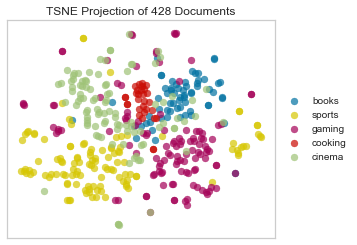

In [69]:
#http://www.scikit-yb.org/en/latest/api/text/tsne.html

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X_tfidf, Y)
tsne.poof()

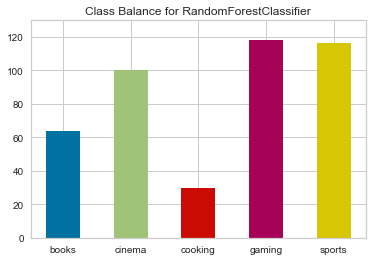

In [67]:
from yellowbrick.classifier import ClassBalance
classes = ['books','cinema','cooking','gaming','sports',]

# Instantiate the classification model and visualizer
visualizer = ClassBalance(rfc, classes= classes)

visualizer.fit(X_tfidf, Y)  # Fit the training data to the visualizer
visualizer.score(X_tfidf, Y)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


## Upsampling
For predictive models.

In [11]:
# Upsample categories so they are 128
df_majority = df[df.topic=='gaming']

df_cooking = resample(df[df['topic'] == 'cooking'], 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))    # to match majority class

df_books = resample(df[df['topic'] == 'books'], 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))    # to match majority class

df_cinema = resample(df[df['topic'] == 'cinema'], 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))    # to match majority class

df_sports = resample(df[df['topic'] == 'sports'], 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))    # to match majority class
                                 
# Combine majority class with upsampled minority class
df2 = pd.concat([df_majority, df_sports, df_cinema, df_books, df_cooking])

df2 = df2.reset_index(drop=True)

# Display new class counts
df2.topic.value_counts()

books      118
cinema     118
gaming     118
sports     118
cooking    118
Name: topic, dtype: int64

In [12]:
# tfidf
X2 = df2['text']
Y2 = df2['topic']

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer articles and shorter articles get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer to training set
X2_tfidf = vectorizer.fit_transform(X2)
print("Number of features: %d" % X2_tfidf.get_shape()[1])

df2['tfidf'] = X2_tfidf


#Reshapes the vectorizer output into something people can read
X2_tfidf_csr = X2_tfidf.tocsr()


#number of tweets
n = X2_tfidf_csr.shape[0]
print('number of articles: %d' %n)


#A list of dictionaries, one per tweet
tfidf_byart = [{} for _ in range(0,n)]


#List of features
terms = vectorizer.get_feature_names()

Number of features: 8866
number of articles: 590


In [13]:
#for each article, lists the feature words and their tf-idf scores
for i, j in zip(*X2_tfidf_csr.nonzero()):
    tfidf_byart[i][terms[j]] = X2_tfidf_csr[i, j]

In [14]:
df2.head()

,text,topic,tfidf
0,"It is that time of year again, the long threat...",gaming,"(0, 8051)\t0.07518988385823872\n (0, 8817)\..."
1,Mercenaries come to life instead in the (typo-...,gaming,"(0, 8051)\t0.07518988385823872\n (0, 8817)\..."
2,Microsoft has a flurry of new Xbox One feature...,gaming,"(0, 8051)\t0.07518988385823872\n (0, 8817)\..."
3,It's hard to tell from this flat trade show de...,gaming,"(0, 8051)\t0.07518988385823872\n (0, 8817)\..."
4,It's not just Rocket League that's getting DLC...,gaming,"(0, 8051)\t0.07518988385823872\n (0, 8817)\..."


# Battle Plan

- Supervised learning models (features: tfidf vectors? BoW?) that categorize articles into topics.  Determine best model. Test-Train split.
- k means clustering.  Which topics are clustered together?
- Unsupervised learning: determine topic sentence for each topic and keywords (shared and unique).  Determine unique topics within a topic.

# Supervised Learning models
Training models to recognize topics.

In [18]:
# Train-test split
Y2 = df2['topic']
X2 = X2_tfidf

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, 
                                                    Y2,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=Y2
                                                   )

## Random Forest

Overfitted. tfidf isn't probably the best thing to fit into the random forest model. Also class imbalance.  Upsampling needed so all categories have 120 cases. 

Play around the depth parameters.  More deep = More prone to overfit

Stilll do test-train split?

In [19]:
rfc = ensemble.RandomForestClassifier()
train = rfc.fit(X2_train, y2_train)

print('Training set score:', rfc.score(X2_train, y2_train))
print('\nTest set score:', rfc.score(X2_test, y2_test))

Training set score: 0.9975786924939467

Test set score: 0.8135593220338984


In [21]:
cross_val_score(rfc, X2, Y2, cv=10)

array([0.88333333, 0.9       , 0.9       , 0.86666667, 0.86666667,
       0.88333333, 0.81666667, 0.93333333, 0.87272727, 0.92727273])

In [22]:
y2_pred = rfc.fit(X2_train, y2_train).predict(X2_test)

In [23]:
# Taking a look at the confusion matrix
pd.crosstab(y2_test, y2_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,books,cinema,cooking,gaming,sports,All
True,,,,,,
books,32,0,2,1,0,35
cinema,4,28,1,2,0,35
cooking,0,0,35,0,0,35
gaming,7,1,0,25,3,36
sports,2,0,0,3,31,36
All,45,29,38,31,34,177


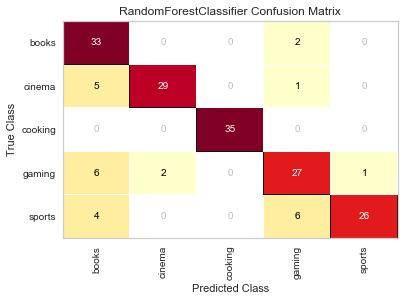

In [24]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(rfc, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X2_train, y2_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X2_test, y2_test)

# How did we do?
cm.poof()

## Multinomial Logistic Regression

In [25]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
train = lr.fit(X2_train, y2_train)

print('Training set score:', lr.score(X2_train, y2_train))
print('\nTest set score:', lr.score(X2_test, y2_test))

Training set score: 0.9975786924939467

Test set score: 0.9661016949152542


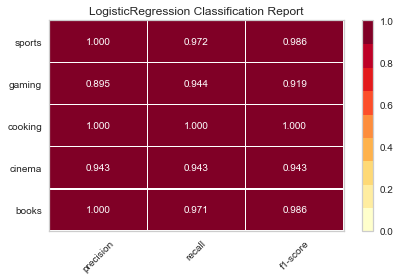

In [26]:
visualizer = ClassificationReport(lr)

visualizer.fit(X2_train, y2_train)
visualizer.score(X2_test, y2_test)
visualizer.poof()

In [27]:
cross_val_score(lr, X2, Y2, cv=10)

array([0.96666667, 1.        , 0.98333333, 0.96666667, 0.98333333,
       0.96666667, 0.9       , 0.98333333, 0.96363636, 0.96363636])

In [28]:
y_pred = lr.fit(X2_train, y2_train).predict(X2_test)

# Taking a look at the confusion matrix
pd.crosstab(y2_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,books,cinema,cooking,gaming,sports,All
True,,,,,,
books,34,0,0,1,0,35
cinema,0,33,0,2,0,35
cooking,0,0,35,0,0,35
gaming,0,2,0,34,0,36
sports,0,0,0,1,35,36
All,34,35,35,38,35,177


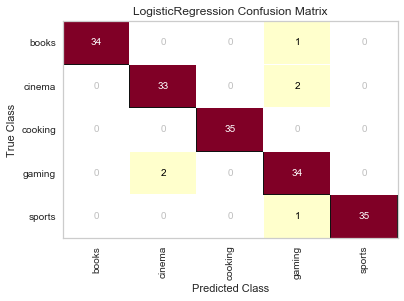

In [29]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(lr, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X2_train, y2_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X2_test, y2_test)

# How did we do?
cm.poof()

## Gradient Boost

In [30]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X2_train, y2_train)

print('Training set score:', clf.score(X2_train, y2_train))
print('\nTest set score:', clf.score(X2_test, y2_test))

Training set score: 1.0

Test set score: 0.9096045197740112


In [31]:
cross_val_score(clf, X2, Y2, cv=10)

array([0.88333333, 0.93333333, 0.9       , 0.93333333, 0.96666667,
       0.9       , 0.91666667, 0.96666667, 0.87272727, 0.94545455])

In [32]:
y_pred = clf.fit(X2_train, y2_train).predict(X2_test)

# Taking a look at the confusion matrix
pd.crosstab(y2_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,books,cinema,cooking,gaming,sports,All
True,,,,,,
books,32,2,0,1,0,35
cinema,2,30,0,1,2,35
cooking,0,0,35,0,0,35
gaming,2,1,0,33,0,36
sports,0,3,0,2,31,36
All,36,36,35,37,33,177


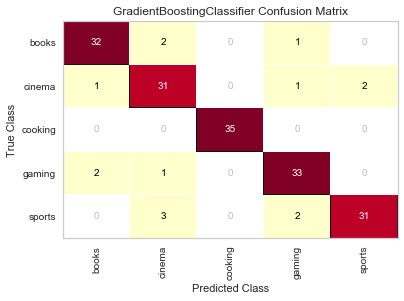

In [33]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(clf, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X2_train, y2_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X2_test, y2_test)

# How did we do?
cm.poof()

# Clustering

Run clusters without upsampling.  A lot of the cooking cases will stick together since cooking is upsampled.

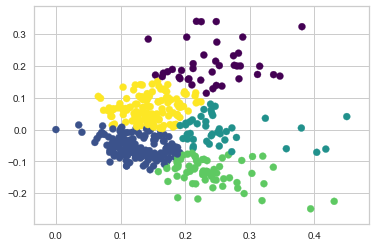

Comparing k-means clusters against the data:
topic  books  cinema  cooking  gaming  sports
row_0                                        
0          0       0        0       0      40
1         38      49       28      27       1
2          1       7        0      29       4
3         25      36        2       5       0
4          0       8        0      57      71


In [34]:
# We are limiting our feature space to 2 components here. 
#  This makes it easier to graph and see the clusters.
svd= TruncatedSVD(2)

# Normalize the data.
X_norm = normalize(X_tfidf)

# Reduce it to two components.
X_svd = svd.fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred, cmap='viridis')
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

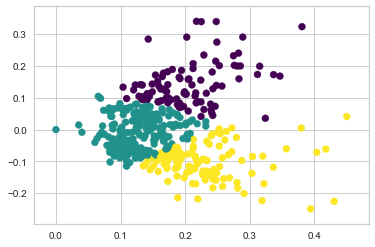

Comparing k-means clusters against the data:
topic  books  cinema  cooking  gaming  sports
row_0                                        
0          0       3        0      11      81
1         32      42       24      84      34
2         32      55        6      23       1


In [35]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred, cmap='viridis')
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

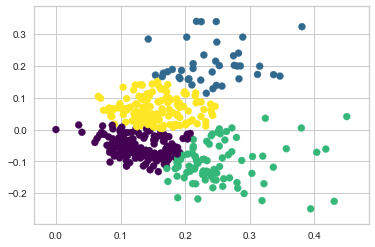

Comparing k-means clusters against the data:
topic  books  cinema  cooking  gaming  sports
row_0                                        
0         38      53       28      30       1
1          0       0        0       0      40
2         26      37        2      22       1
3          0      10        0      66      74


In [36]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred, cmap='viridis')
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

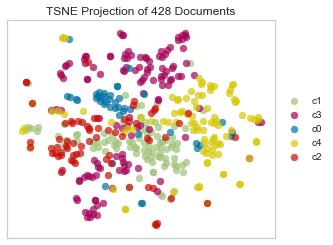

In [37]:
# Apply clustering instead of class names.
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=5)
clusters.fit(X_tfidf)

tsne = TSNEVisualizer()
tsne.fit(X_tfidf, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()

# Topic Sentence
Find main sentence for each article, then a topic topic sentence for each topic?

In [38]:
df.count()

text     428
topic    428
tfidf    428
dtype: int64

In [39]:
parser = spacy.load('en')

parsed = []
for r in range(len(df)):
    try:
        parsed_text = parser(df['text'][r])
        parsed.append(parsed_text)
    except KeyError:
        pass  

In [40]:
df['parsed'] = parsed

In [41]:
def main_sent(text):    
    sentences=[]

    for span in text.sents:
            # go from the start to the end of each span, returning each token in the sentence
            # combine each token using join()
        sent = ''.join(text[i].string for i in range(span.start, span.end)).strip()
        sentences.append(sent)

        # Creating the tf-idf matrix.
    counter = TfidfVectorizer(lowercase=False, 
                              stop_words=None,
                              ngram_range=(1, 1), 
                              analyzer=u'word', 
                              max_df=.5, 
                              min_df=1,
                              max_features=None, 
                              vocabulary=None, 
                              binary=False)

        #Applying the vectorizer
    data_counts=counter.fit_transform(sentences)

    # Calculating similarity
    similarity = data_counts * data_counts.T

    # Identifying the sentence with the highest rank.
    nx_graph = nx.from_scipy_sparse_matrix(similarity)
    ranks=nx.pagerank(nx_graph, alpha=.85, tol=.00000001)

    ranked = sorted(((ranks[i],s) for i,s in enumerate(sentences)),
                    reverse=True)
    
    return(ranked[0][1])

In [42]:
main_sentences = []

for r in range(len(df)):
    try:
        m = main_sent(df['parsed'][r]) 
        main_sentences.append(m)
    except ValueError:
        main_sentences.append(np.nan)
        


In [43]:
df3 = pd.DataFrame()
df3['topic'] = df['topic']
df3['main_sentence'] = main_sentences

In [44]:
df3.head()

,topic,main_sentence
0,books,While two out of the past three Best Actress w...
1,books,"The Lonely City, an exploration of loneliness ..."
2,books,There are doppelgängers throughout the stories...
3,books,The new graphic novel by Malaysia-born cartoon...
4,books,"You do you, Nash."


In [45]:
parser = spacy.load('en')

parsed = []
for r in range(len(df3)):
    try:
        parsed_text = parser(df3['main_sentence'][r])
        parsed.append(parsed_text)
    except TypeError:
        parsed.append(np.nan) 

In [46]:
df3['parsed'] = parsed

In [47]:
df3 = df3.dropna().reset_index(drop=True)

In [48]:
X3 = df3['main_sentence']
Y3 = df3['topic']

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer tweets and shorter tweets get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer to training set
X3_tfidf = vectorizer.fit_transform(X3)
print("Number of features: %d" % X3_tfidf.get_shape()[1])



#Reshapes the vectorizer output into something people can read
X3_tfidf_csr = X3_tfidf.tocsr()


#number of tweets
n = X3_tfidf_csr.shape[0]
print('number of sents: %d' %n)


#A list of dictionaries, one per tweet
tfidf_bysent = [{} for _ in range(0,n)]


#List of features
terms = vectorizer.get_feature_names()

Number of features: 515
number of sents: 427


In [49]:
#for each tweet, lists the feature words and their tf-idf scores
for i, j in zip(*X3_tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = X3_tfidf_csr[i, j]

## LSA

In [50]:
#Our SVD data reducer.  We are going to reduce the feature space to 200 components.
svd= TruncatedSVD(200)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_lsa = lsa.fit_transform(X3_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100, '\n')

#Looking at what sorts of tweets our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_lsa, index=X3)
for i in range(10):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])
    print('\n')

Percent variance captured by all components: 84.20970015320705 

Component 0:
main_sentence
Luke Pope, developer of award-winning indie game Papers, Please, has launched a new demo for his next game, Return of the Obra Dinn.                                                                                   0.419315
Now that we know the release date of Square Enix’s next Star Ocean game, it’s time to learn more about the game.                                                                                                       0.415121
If you don't know anything about the game,    is the digital version of the Kickstarter-darling card game that broke many records and landed on many tables.                                                           0.400540
Like AMC's post-Walking Dead talkshow series, The Talking Dead, HBO has a new show that will air on Mondays following the newest episode of Game of Thrones called After the Thrones.                                  0.399371
Stevens and 

# Keywords
What are the key words for each topic?

enumerate takes an object an generates an iterator.
http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/

Google python enumerate over ngrams
spacy.doc ngrams

In [51]:
def keywords(text):
    # Removing stop words and punctuation, then getting a list of all unique words in the text
    text_filt = [word for word in text if word.is_stop==False and (word.pos_=='NOUN' or word.pos_=='ADJ')]
    words=set(text_filt)

    #Creating a grid indicating whether words are within 4 places of the target word
    adjacency=pd.DataFrame(columns=words,index=words,data=0)

    #Iterating through each word in the text and indicating which of the unique words are its neighbors
    for i,word in enumerate(text):
        # Checking if any of the word's next four neighbors are in the word list 
        if any([word == item for item in text_filt]):
            # Making sure to stop at the end of the string, even if there are less than four words left after the target.
            end=max(0,len(text)-(len(text)-(i+5)))
            # The potential neighbors.
            nextwords=text[i+1:end]
            # Filtering the neighbors to select only those in the word list
            inset=[x in text_filt for x in nextwords]
            neighbors=[nextwords[i] for i in range(len(nextwords)) if inset[i]]
            # Adding 1 to the adjacency matrix for neighbors of the target word
            if neighbors:
                adjacency.loc[word,neighbors]=adjacency.loc[word,neighbors]+1

    print('done!')
    
    # Running TextRank
    nx_words = nx.from_numpy_matrix(adjacency.as_matrix())
    ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)

    # Identifying the five most highly ranked keywords
    ranked = sorted(((ranks[i],s) for i,s in enumerate(words)),
                    reverse=True)
    print(ranked[:5])

In [52]:
books = ' '.join(df[df['topic']=='books']['text'])
books_parsed = parser(books)

In [53]:
keywords(books_parsed)

done!
[(0.00019088158152087389, interests), (0.00018940362751230556, volumes), (0.00018919414331158596, world), (0.0001876679473457359, work), (0.0001876679473457359, man)]


In [54]:
sports = ' '.join(df[df['topic']=='sports']['text'])
sports_parsed = parser(sports)

keywords(sports_parsed)

done!
[(0.0001533136904219879, relationship), (0.0001521266160668421, 2-guard), (0.0001521266160668421, offseason), (0.00015073253943664237, leader), (0.00015073253943664237, competition)]


In [55]:
gaming = ' '.join(df[df['topic']=='gaming']['text'])
gaming_parsed = parser(gaming)

keywords(gaming_parsed)

done!
[(0.00011753231325066225, Risk), (0.00011451269934348021, writer), (0.0001145126993434802, cars), (0.0001145126993434802, cars), (0.00011398573415603492, kind)]


In [56]:
cooking = ' '.join(df[df['topic']=='cooking']['text'])
cooking_parsed = parser(cooking)

keywords(cooking_parsed)

done!
[(0.00020984223227158216, jackfruit), (0.00020275693603646344, squeeze), (0.000200261210766853, optional), (0.00020026121076685297, thanks), (0.00019934337169598068, way)]


In [57]:
cinema = ' '.join(df[df['topic']=='cinema']['text'])
cinema_parsed = parser(cinema)

keywords(cinema_parsed)

done!
[(0.000135184208071151, pic), (0.00013167426651464632, players), (0.00013167426651464632, second), (0.00013167426651464632, members), (0.00013167426651464632, contrast)]


ALTERNATIVE WAY TO LOOK AT KEY WORDS
http://www.scikit-yb.org/en/latest/api/text/freqdist.html

# nGrams

In [58]:
# Creates ngrams
# From stackoverflow thread: https://stackoverflow.com/
#    questions/12488722/counting-bigrams-pair-of-two-words-in-a-file-using-python
def ngrams(lst, n):
  tlst = lst
  while True:
    a, b = tee(tlst)
    l = tuple(islice(a, n))
    if len(l) == n:
      yield l
      next(b)
      tlst = b
    else:
      break

# Removes punctuation and numbers. Returns token string
def no_punc(text):
    # Removes apostrophes (badly...)
    text = text.replace("'", "")
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Removes punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    token_string = ' '.join(tokens)
    
    return token_string


def find_ngrams(text, n):
    token_string = no_punc(text)
    
    words = nltk.word_tokenize(token_string)
    word_count = Counter(ngrams(words, n))
    most_common = word_count.most_common()[:5]
    
    return most_common

In [59]:
find_ngrams(books,3)

[(('a', 'lot', 'of'), 15),
 (('I', 'don', 't'), 11),
 (('I', 'didn', 't'), 11),
 (('one', 'of', 'the'), 10),
 (('of', 'the', 'world'), 9)]

In [70]:
topics = {'books':books, 'cinema':cinema, 'cooking':cooking, 'sports':sports, 'gaming':gaming}

for k, v in topics.items():
    print(k + '\n')
    print(find_ngrams(v, 3)) 
    print('\n')

books

[(('a', 'lot', 'of'), 15), (('I', 'don', 't'), 11), (('I', 'didn', 't'), 11), (('one', 'of', 'the'), 10), (('of', 'the', 'world'), 9)]


cinema

[(('a', 'lot', 'of'), 22), (('one', 'of', 'the'), 21), (('as', 'well', 'as'), 18), (('some', 'of', 'the'), 14), (('in', 'the', 'film'), 13)]


cooking

[(('t', 'wait', 'to'), 16), (('and', 'it', 'was'), 15), (('I', 'can', 't'), 13), (('in', 'the', 'oven'), 13), (('you', 'want', 'to'), 13)]


sports

[(('one', 'of', 'the'), 34), (('Offseason', 'Workouts', 'May'), 32), (('Mandatory', 'Minicamp', 'June'), 32), (('Report', 'April', 'OTA'), 31), (('April', 'OTA', 'Offseason'), 31)]


gaming

[(('a', 'lot', 'of'), 36), (('Gears', 'of', 'War'), 28), (('one', 'of', 'the'), 22), (('you', 'want', 'to'), 19), (('to', 'be', 'a'), 17)]




# NEXT STEPS
- Try it out on a larger corpus.
- Streamline processes with pipelines and classes
